## **Conditional DDPM on CIFAR-10 dataset** 

This notebook trains 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set device and hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
num_epochs = 100
learning_rate = 0.0002
beta_start = 0.0001
beta_end = 0.02
timesteps = 1000
num_classes = 10
dropout_prob = 0.1
base_channels = 64

In [3]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for 3 channels
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, transform=transform, download=True
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [4]:
# Define Complex Conditional U-Net
class ConditionalUNet(nn.Module):
    def __init__(self, num_classes, base_channels=64):
        super(ConditionalUNet, self).__init__()
        
        self.class_emb = nn.Embedding(num_classes + 1, base_channels)
        
        # Encoder: Input has 3 channels (RGB)
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, base_channels, 3, padding=1), nn.ReLU(),  # Changed from 1 to 3 channels
            nn.Conv2d(base_channels, base_channels, 3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)
        
        self.middle = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 4, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base_channels * 4, base_channels * 4, 3, padding=1), nn.ReLU()
        )
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(base_channels * 4 + base_channels, base_channels * 2, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding=1), nn.ReLU()
        )
        
        self.up2 = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(base_channels * 2 + base_channels, base_channels, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base_channels, base_channels, 3, padding=1), nn.ReLU()
        )
        
        # Output has 3 channels (RGB)
        self.final = nn.Conv2d(base_channels, 3, 1)  # Changed from 1 to 3 channels
        
    def forward(self, x, class_labels):
        class_emb = self.class_emb(class_labels).unsqueeze(-1).unsqueeze(-1)
        
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        
        m = self.middle(p2)
        
        u1 = self.up1(m)
        class_emb_resized = class_emb.expand(-1, -1, u1.shape[2], u1.shape[3])
        d1_input = torch.cat([u1, e2, class_emb_resized], dim=1)
        d1 = self.dec1(d1_input)
        
        u2 = self.up2(d1)
        class_emb_resized = class_emb.expand(-1, -1, u2.shape[2], u2.shape[3])
        d2_input = torch.cat([u2, e1, class_emb_resized], dim=1)
        d2 = self.dec2(d2_input)
        
        return torch.tanh(self.final(d2))

In [5]:
# Diffusion schedule
def get_betas(timesteps):
    betas = torch.linspace(beta_start, beta_end, timesteps)
    return betas.to(device)

def get_alphas(betas):
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    return alphas, alphas_cumprod

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    
    betas = get_betas(timesteps)
    alphas, alphas_cumprod = get_alphas(betas)
    
    # Index alphas_cumprod with t and reshape for broadcasting
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod[t]).view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod[t]).view(-1, 1, 1, 1)
    
    # Ensure shapes match for broadcasting
    sqrt_alphas_cumprod = sqrt_alphas_cumprod.expand_as(x_start)
    sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.expand_as(x_start)
    
    return (sqrt_alphas_cumprod * x_start + sqrt_one_minus_alphas_cumprod * noise)

In [6]:
# Training setup
model = ConditionalUNet(num_classes, base_channels).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

betas = get_betas(timesteps)
alphas, alphas_cumprod = get_alphas(betas)

In [7]:
def train_model():
    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            batch_size = images.shape[0]
            
            t = torch.randint(0, timesteps, (batch_size,), device=device)
            mask = (torch.rand(batch_size, device=device) > dropout_prob).long()
            conditioned_labels = labels * mask + (1 - mask) * num_classes
            
            noise = torch.randn_like(images)
            x_noisy = q_sample(images, t, noise)
            predicted_noise = model(x_noisy, conditioned_labels)
            
            loss = criterion(predicted_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if i % 100 == 0:
                print(f'Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')
        
        # Average loss for the epoch
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
    
    return losses

In [8]:
losses = train_model()

Epoch [0/100], Step [0/391], Loss: 1.0085
Epoch [0/100], Step [100/391], Loss: 0.2726
Epoch [0/100], Step [200/391], Loss: 0.2715
Epoch [0/100], Step [300/391], Loss: 0.2401
Epoch [1/100], Step [0/391], Loss: 0.2330
Epoch [1/100], Step [100/391], Loss: 0.2275
Epoch [1/100], Step [200/391], Loss: 0.2194
Epoch [1/100], Step [300/391], Loss: 0.2187
Epoch [2/100], Step [0/391], Loss: 0.2214
Epoch [2/100], Step [100/391], Loss: 0.2076
Epoch [2/100], Step [200/391], Loss: 0.2232
Epoch [2/100], Step [300/391], Loss: 0.2223
Epoch [3/100], Step [0/391], Loss: 0.2075
Epoch [3/100], Step [100/391], Loss: 0.2122
Epoch [3/100], Step [200/391], Loss: 0.2042
Epoch [3/100], Step [300/391], Loss: 0.2046
Epoch [4/100], Step [0/391], Loss: 0.2114
Epoch [4/100], Step [100/391], Loss: 0.2088
Epoch [4/100], Step [200/391], Loss: 0.1950
Epoch [4/100], Step [300/391], Loss: 0.2094
Epoch [5/100], Step [0/391], Loss: 0.1889
Epoch [5/100], Step [100/391], Loss: 0.1928
Epoch [5/100], Step [200/391], Loss: 0.2012


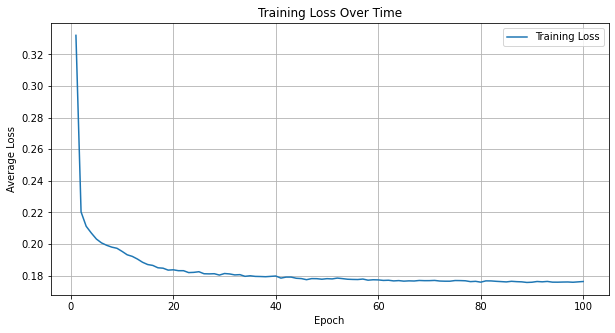

In [9]:
# Part 1: Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.legend()
plt.show()

In [10]:
# Cell 8: Conditional sampling with trajectory
@torch.no_grad()
def sample_conditional(model, num_samples=1, class_label=None, guidance_scale=3.0, save_trajectory=False):
    model.eval()
    x = torch.randn(num_samples, 3, 32, 32).to(device)  # Updated for CIFAR-10 (3 channels, 32x32)
    
    if class_label is None:
        labels = torch.arange(num_samples) % num_classes
    else:
        labels = torch.full((num_samples,), class_label, dtype=torch.long)
    labels = labels.to(device)
    null_labels = torch.full((num_samples,), num_classes, dtype=torch.long).to(device)
    
    trajectory = [x.cpu().numpy()] if save_trajectory else None
    
    for t in reversed(range(timesteps)):
        t_tensor = torch.full((num_samples,), t, device=device)
        pred_noise_cond = model(x, labels)
        pred_noise_uncond = model(x, null_labels)
        predicted_noise = pred_noise_uncond + guidance_scale * (pred_noise_cond - pred_noise_uncond)
        
        betas_t = betas[t]
        alphas_t = alphas[t]
        alphas_cumprod_t = alphas_cumprod[t]
        
        x = (1 / torch.sqrt(alphas_t)) * (
            x - ((1 - alphas_t) / torch.sqrt(1 - alphas_cumprod_t)) * predicted_noise
        )
        
        if t > 0:
            x = x + torch.sqrt(betas_t) * torch.randn_like(x)
        
        if save_trajectory and t % 100 == 0:
            trajectory.append(x.cpu().numpy())
    
    return x, trajectory

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

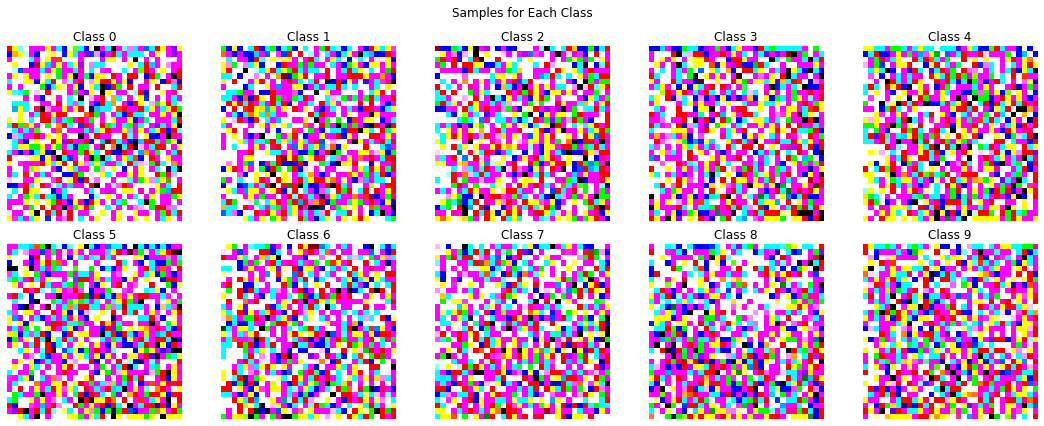

In [11]:
# Part 2: Samples for different class conditions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    samples, _ = sample_conditional(model, num_samples=1, class_label=i)
    samples = samples.cpu().numpy()
    ax = axes[i // 5, i % 5]
    # Transpose for visualization (C, H, W) -> (H, W, C)
    ax.imshow(np.transpose(samples[0], (1, 2, 0)) * 0.5 + 0.5)  # Denormalize for display
    ax.set_title(f'Class {i}')
    ax.axis('off')
plt.suptitle("Samples for Each Class")
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

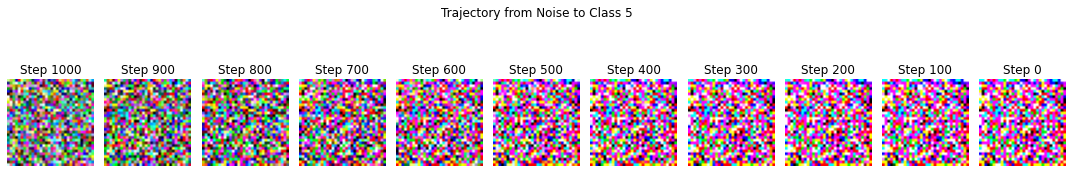

In [12]:
# Part 3: Trajectory for class 5
samples, trajectory = sample_conditional(model, num_samples=1, class_label=5, save_trajectory=True)
trajectory = np.array(trajectory)  # Convert list to numpy array

fig, axes = plt.subplots(1, len(trajectory), figsize=(15, 3))
for i in range(len(trajectory)):
    img = trajectory[i][0]  # Shape: (C, H, W)
    img = np.transpose(img, (1, 2, 0)) * 0.5 + 0.5  # Transpose and denormalize
    axes[i].imshow(img)
    axes[i].set_title(f'Step {timesteps - (i * 100)}')
    axes[i].axis('off')
plt.suptitle("Trajectory from Noise to Class 5")
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


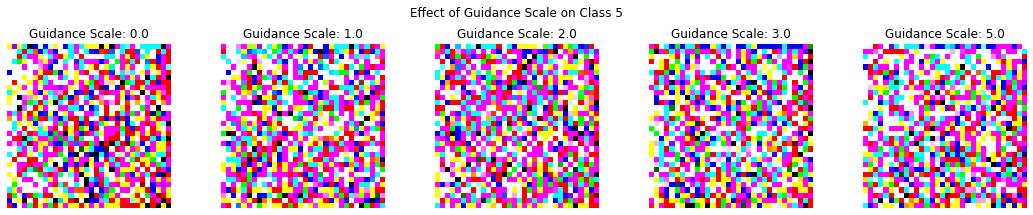

In [13]:
# Part 4: Samples with different guidance scales for class 5
guidance_scales = [0.0, 1.0, 2.0, 3.0, 5.0]
fig, axes = plt.subplots(1, len(guidance_scales), figsize=(15, 3))

for i, scale in enumerate(guidance_scales):
    samples, _ = sample_conditional(model, num_samples=1, class_label=5, guidance_scale=scale)
    samples = samples.cpu().numpy()
    ax = axes[i]
    ax.imshow(np.transpose(samples[0], (1, 2, 0)) * 0.5 + 0.5)  # Denormalize for display
    ax.set_title(f'Guidance Scale: {scale}')
    ax.axis('off')
plt.suptitle("Effect of Guidance Scale on Class 5")
plt.tight_layout()
plt.show()